In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from opxrd.wrapper import OpXRD

test_dirpath = '/home/daniel/aimat/data/test'
full_dirpath = '/home/daniel/aimat/data/opXRD/full/'
database = OpXRD.load_project_list(root_dirpath=test_dirpath)

ModuleNotFoundError: No module named 'distlib'

In [3]:
from opxrd.analysis import DatabaseAnalyser

analyser = DatabaseAnalyser(databases=database, output_dirpath='/tmp/opxrd_analysis')

---> Combined pattern plot for databaes ['a:EMPA', 'b:LBNL-A', 'c:LBNL-B', 'd:LBNL-C', 'e:LBNL-D', 'f:USC', 'g:INT', 'h:HKUST-A', 'i:HKUST-B', 'j:CNRS', 'k:IKFT'] | No. patterns = 50

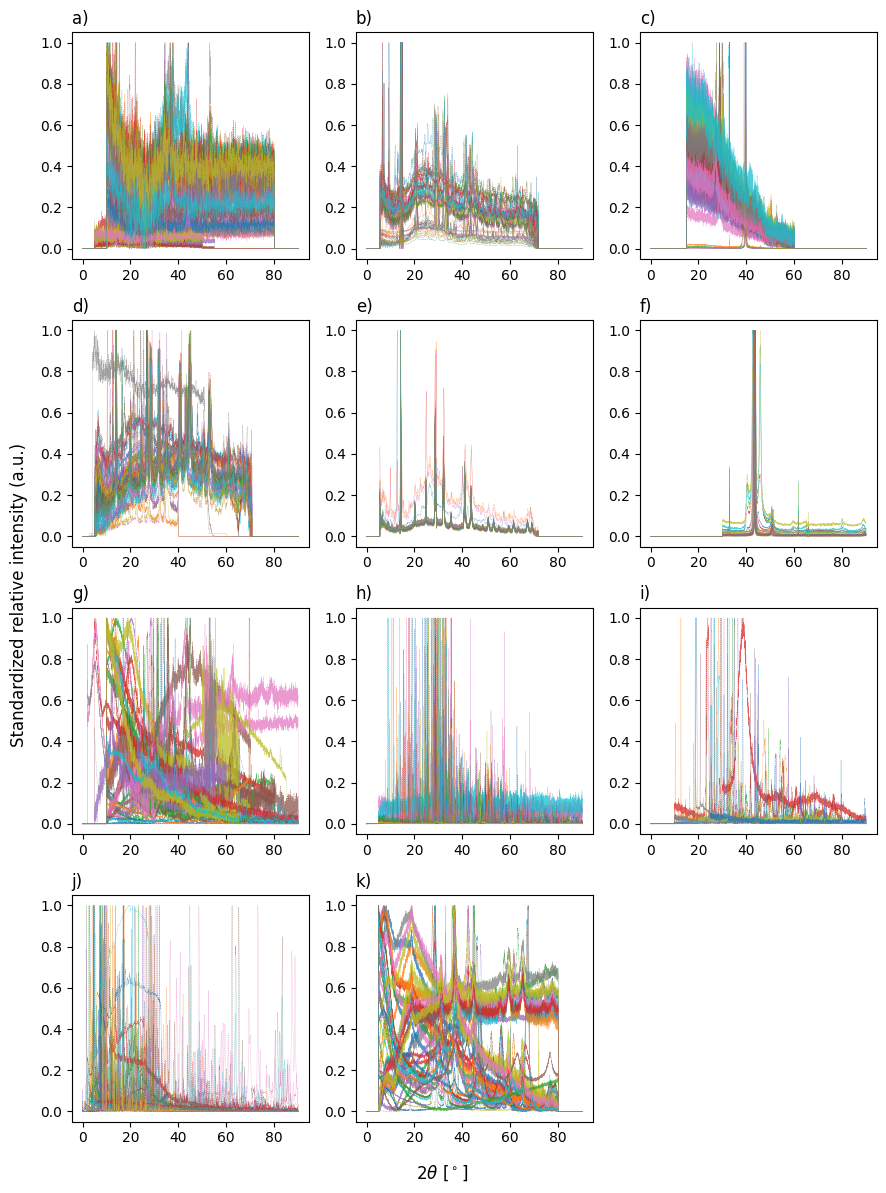

In [8]:
analyser.plot_in_single(limit_patterns=50)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for EMPA | No. patterns = 770
[Debug]: Performing PCA for LBNL-A | No. patterns = 28765
[Debug]: Performing PCA for LBNL-B | No. patterns = 342
[Debug]: Performing PCA for LBNL-C | No. patterns = 39557
[Debug]: Performing PCA for LBNL-D | No. patterns = 1348
[Debug]: Performing PCA for USC | No. patterns = 338
[Debug]: Performing PCA for INT | No. patterns = 19796
[Debug]: Performing PCA for HKUST-A | No. patterns = 499
[Debug]: Performing PCA for HKUST-B | No. patterns = 21
[Debug]: Performing PCA for CNRS | No. patterns = 1052


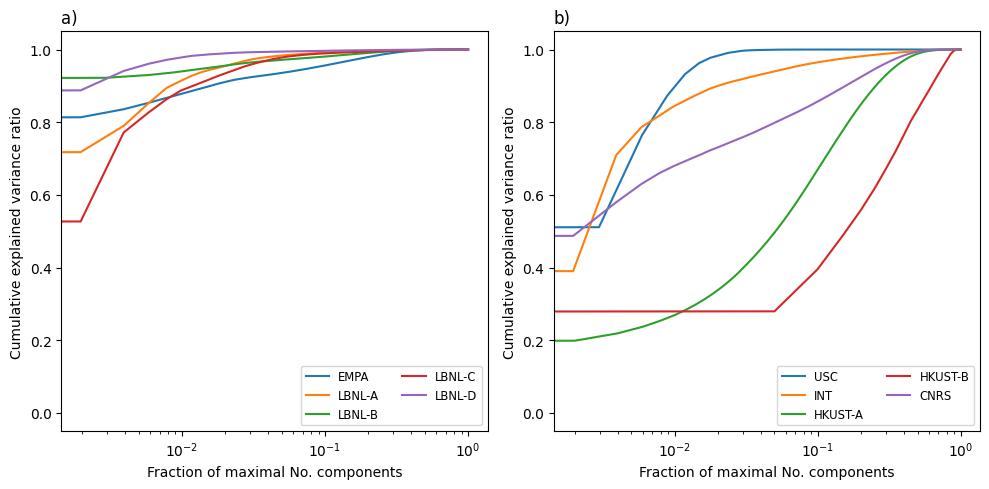

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for EMPA | No. patterns = 770
[Debug]: Performing PCA for LBNL-A | No. patterns = 28765
[Debug]: Performing PCA for LBNL-B | No. patterns = 342
[Debug]: Performing PCA for LBNL-C | No. patterns = 39557
[Debug]: Performing PCA for LBNL-D | No. patterns = 1348
[Debug]: Performing PCA for USC | No. patterns = 338
[Debug]: Performing PCA for INT | No. patterns = 19796
[Debug]: Performing PCA for HKUST-A | No. patterns = 499
[Debug]: Performing PCA for HKUST-B | No. patterns = 21
[Debug]: Performing PCA for CNRS | No. patterns = 1052


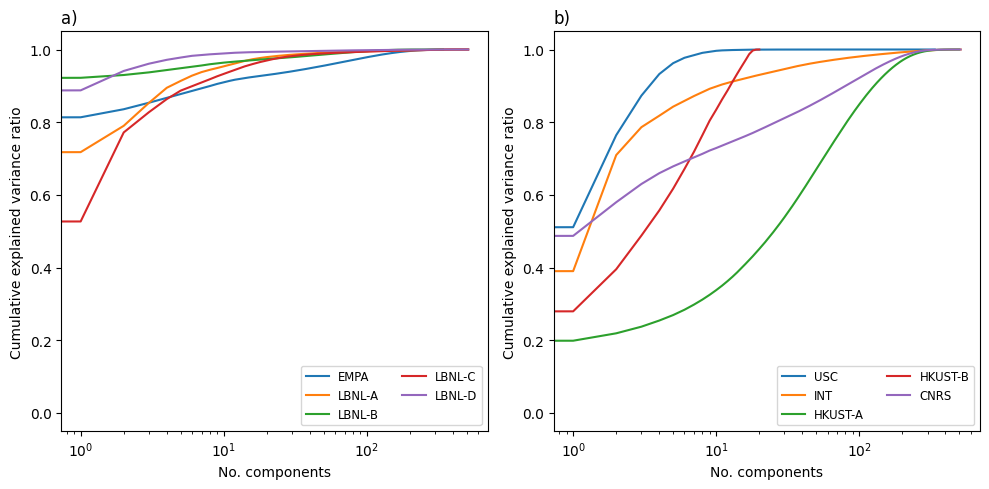

In [11]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

---> Histogram of general information on opXRD

/home/daniel/aimat/xrdpattern/xrdpattern/pattern/visualization.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spg_formulas, rotation=90)


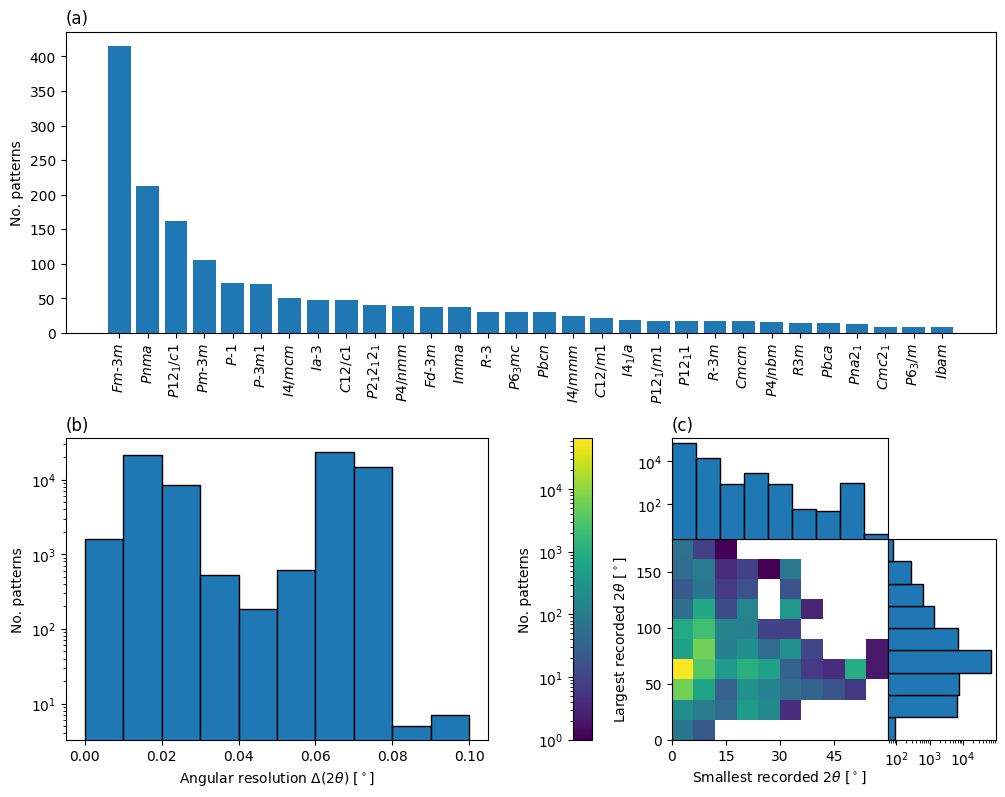

In [12]:
analyser.plot_histogram()

In [16]:
analyser.show_label_fractions()
analyser.print_total_counts()

---> Overview of label fractions per contribution

+---------+----------------+----------+-----------+---------------+---------------+
|         |   No. patterns |      spg |   lattice |   atom_coords |   composition |
|---------+----------------+----------+-----------+---------------+---------------|
| EMPA    |            770 | 0.631169 |  0        |      0        |      0.997403 |
| LBNL-A  |          28765 | 0        |  0        |      0        |      0        |
| LBNL-B  |            342 | 0        |  0        |      0        |      0        |
| LBNL-C  |          39557 | 0        |  0        |      0        |      0        |
| LBNL-D  |           1348 | 0        |  0        |      0        |      0        |
| USC     |            338 | 1        |  0.899408 |      0        |      1        |
| INT     |          19796 | 0        |  0        |      0        |      0        |
| HKUST-A |            499 | 0        |  0        |      0        |      0        |
| HKUST-B |             21 | 1        |  1        |      1        |      0  

---> Total pattern counts in opXRD

Total number of patterns = 92552
Number of labeled patterns = 2179
